In [576]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, normaltest, chisquare, norm
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import sys
# !{sys.executable} -m pip install seaborn
import seaborn as sns
#!{sys.executable} -m pip install -U scikit-learn
from sklearn.linear_model import LinearRegression

In [577]:
df = pd.read_table("./data.txt", dtype={'Actual': float, 'Seasonally adjusted': float, 'Trend': float})
df

,Month,Actual,Seasonally adjusted,Trend
0,Jan-1995,1.506,1.857,1.864
1,Feb-1995,1.214,1.951,1.824
2,Mar-1995,2.060,1.748,1.780
3,Apr-1995,1.479,1.693,1.738
4,May-1995,1.830,1.632,1.701
...,...,...,...,...
341,Jun-2023,3.402,3.330,3.189
342,Jul-2023,3.058,3.144,3.105
343,Aug-2023,3.170,2.928,3.021
344,Sep-2023,2.898,2.795,2.960


### Обзор исходных данных

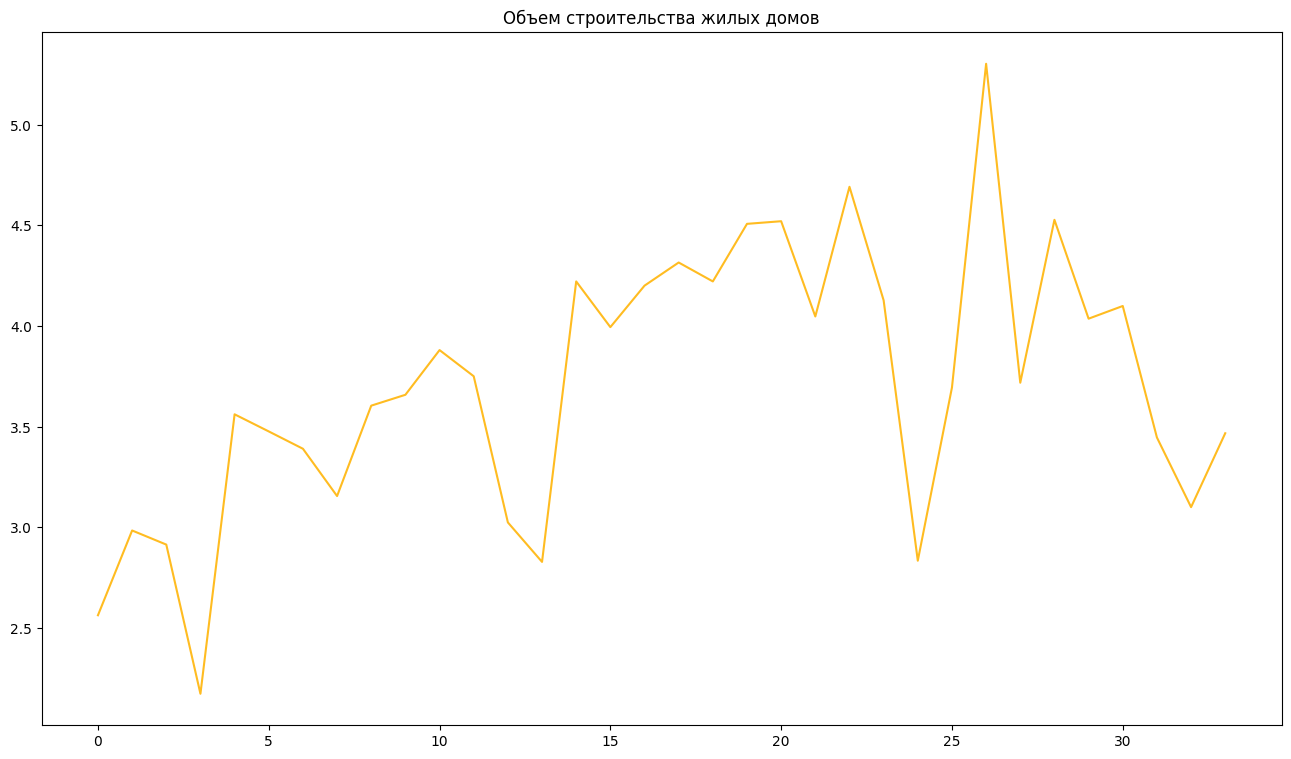

In [578]:
plt.figure(figsize=(16, 9))
plt.title('Объем строительства жилых домов')
plt.plot(range(len(df['Actual'][300:-12])), df['Actual'][300:-12], color='#ffbc21')
plt.show()

In [579]:
data = df[:-10]
data = data.drop(columns=['Seasonally adjusted', 'Trend'])
data['Date'] = data['Month']
data[['Month', 'Year']] = data['Month'].str.split('-', expand=True)
data['Year'] = pd.to_numeric(data['Year'])
data

,Month,Actual,Date,Year
0,Jan,1.506,Jan-1995,1995
1,Feb,1.214,Feb-1995,1995
2,Mar,2.060,Mar-1995,1995
3,Apr,1.479,Apr-1995,1995
4,May,1.830,May-1995,1995
...,...,...,...,...
331,Aug,3.447,Aug-2022,2022
332,Sep,3.101,Sep-2022,2022
333,Oct,3.468,Oct-2022,2022
334,Nov,3.049,Nov-2022,2022


### Обзор по годам

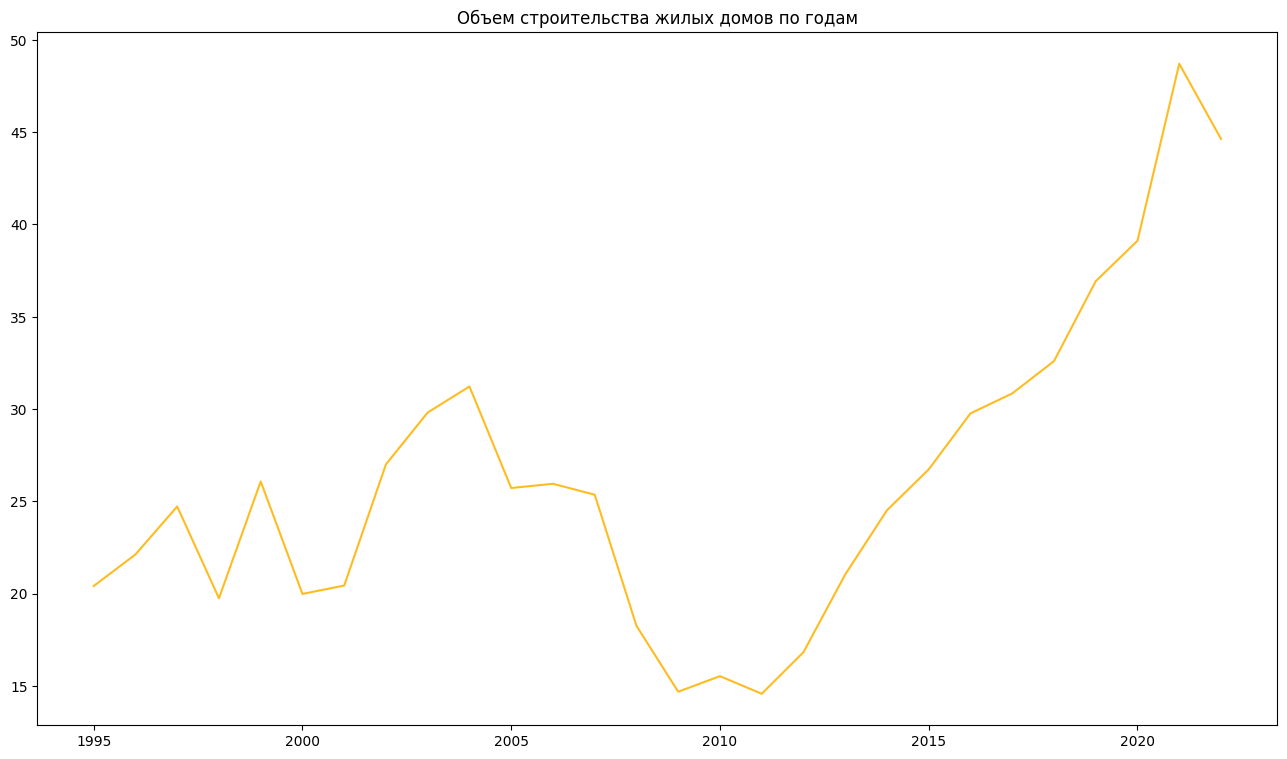

0     20.414
1     22.123
2     24.723
3     19.749
4     26.077
5     19.985
6     20.439
7     27.008
8     29.814
9     31.223
10    25.723
11    25.952
12    25.360
13    18.256
14    14.686
15    15.530
16    14.575
17    16.829
18    21.040
19    24.517
20    26.732
21    29.766
22    30.847
23    32.596
24    36.927
25    39.120
26    48.707
27    44.639
Name: Actual, dtype: float64

In [580]:
data_years = data.groupby('Year')['Actual'].sum().reset_index(drop=True)
plt.figure(figsize=(16, 9))
plt.title('Объем строительства жилых домов по годам')
plt.plot(range(1995, 1995 + len(data_years)), data_years, color='#ffbc21')
plt.show()
data_years

### Рассчет тепра прироста

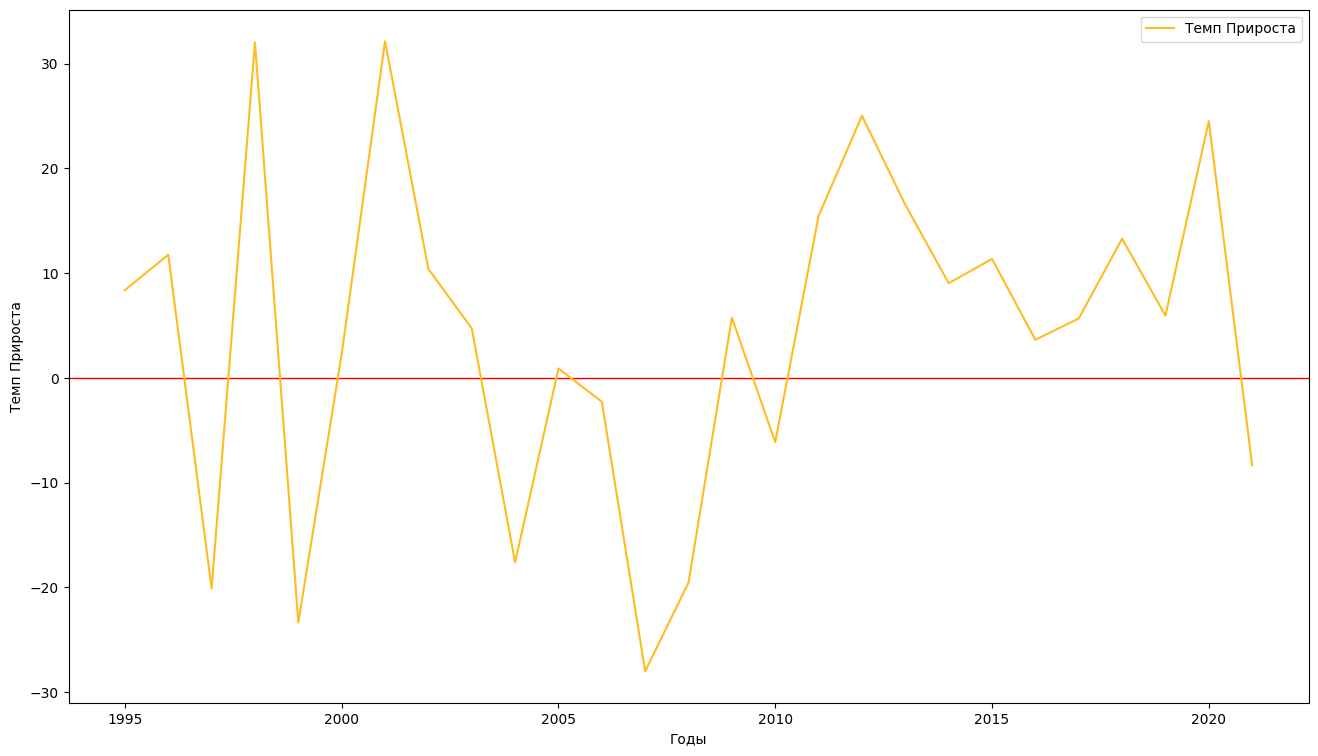

In [581]:
growth_temp = [data_years[i+1] * 100 / data_years[i] for i in range(len(data_years) - 1)]
gain_temp = [x - 100 for x in growth_temp]

fig, ax = plt.subplots(figsize=(16, 9))
ax.axhline(0, color='red', linewidth=1)
sns.lineplot(x=range(1995, 1995 + len(gain_temp)), y=gain_temp, color='#ffbc21', label='Темп Прироста')
plt.xlabel('Годы')
plt.ylabel('Темп Прироста')
plt.show()

### Среднемесяцные значения

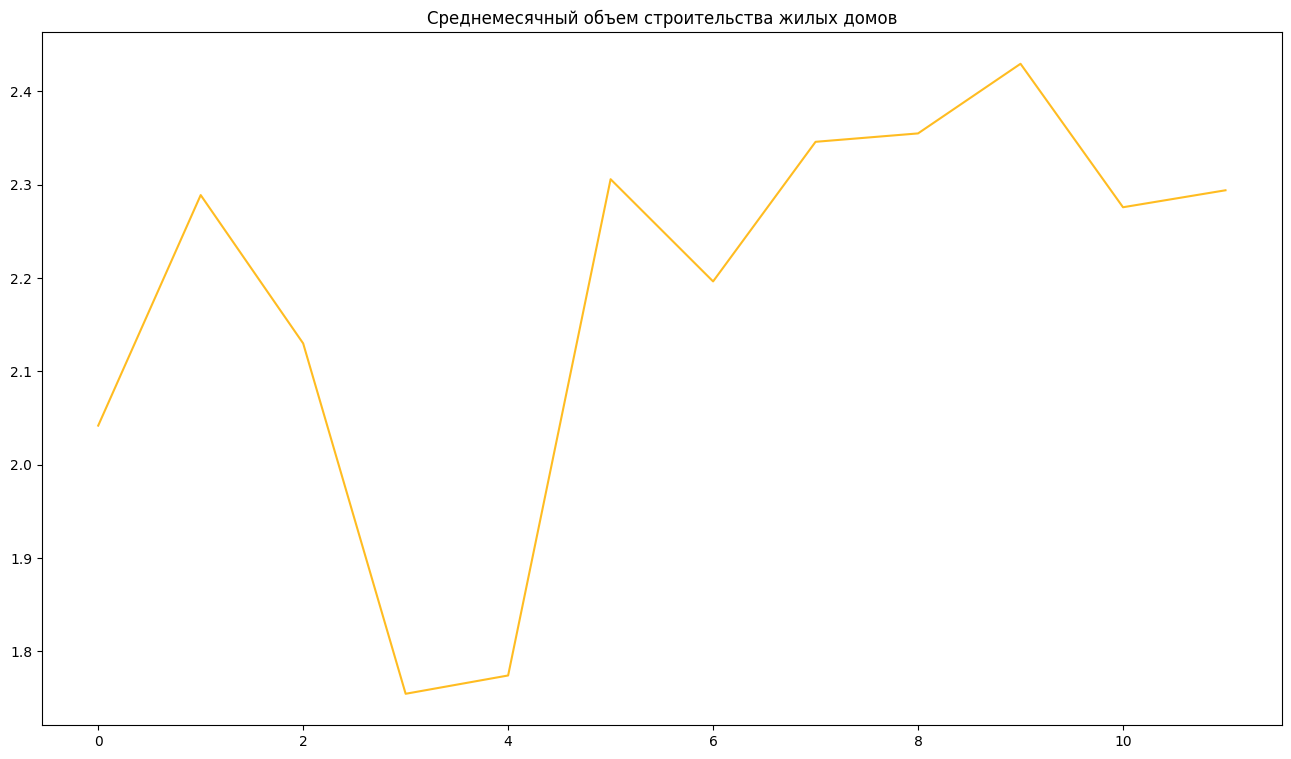

In [582]:
data_months = data.groupby('Month')['Actual'].mean().reset_index(drop=True)
data_months
plt.figure(figsize=(16, 9))
plt.title('Среднемесячный объем строительства жилых домов')
plt.plot(range(len(data_months)), data_months, color='#ffbc21')
plt.show()

### Проверка на нормальность

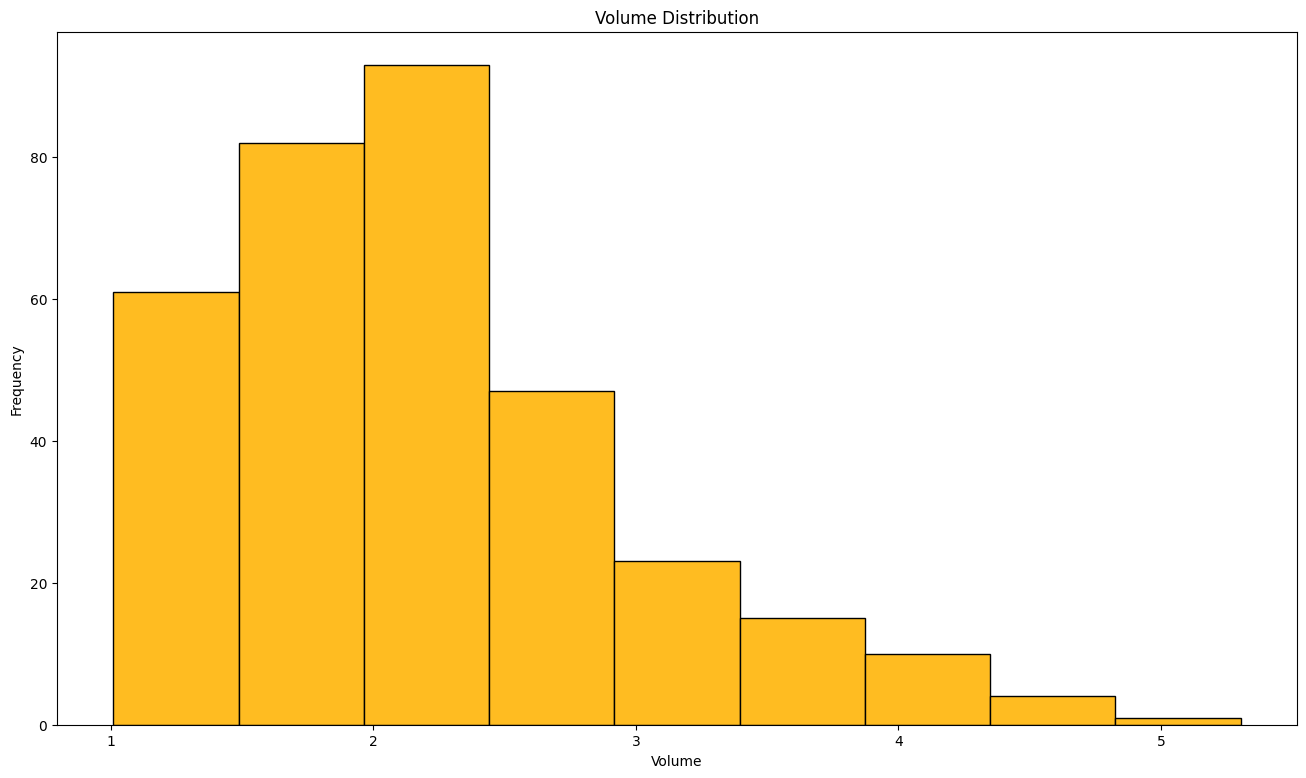

In [583]:
vol = data['Actual']
fig, ax = plt.subplots(figsize=(16, 9))
min_vol, max_vol = min(vol), max(vol)
num_bins = 1 + int(3.2222 * np.log10(len(vol)))
bins = np.linspace(min_vol, max_vol, num_bins + 1)
plt.hist(vol, bins=bins, edgecolor='black', color='#ffbc21')
plt.title(f"Volume Distribution")
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.savefig(f"./assets/volume_hist.png")
plt.show()

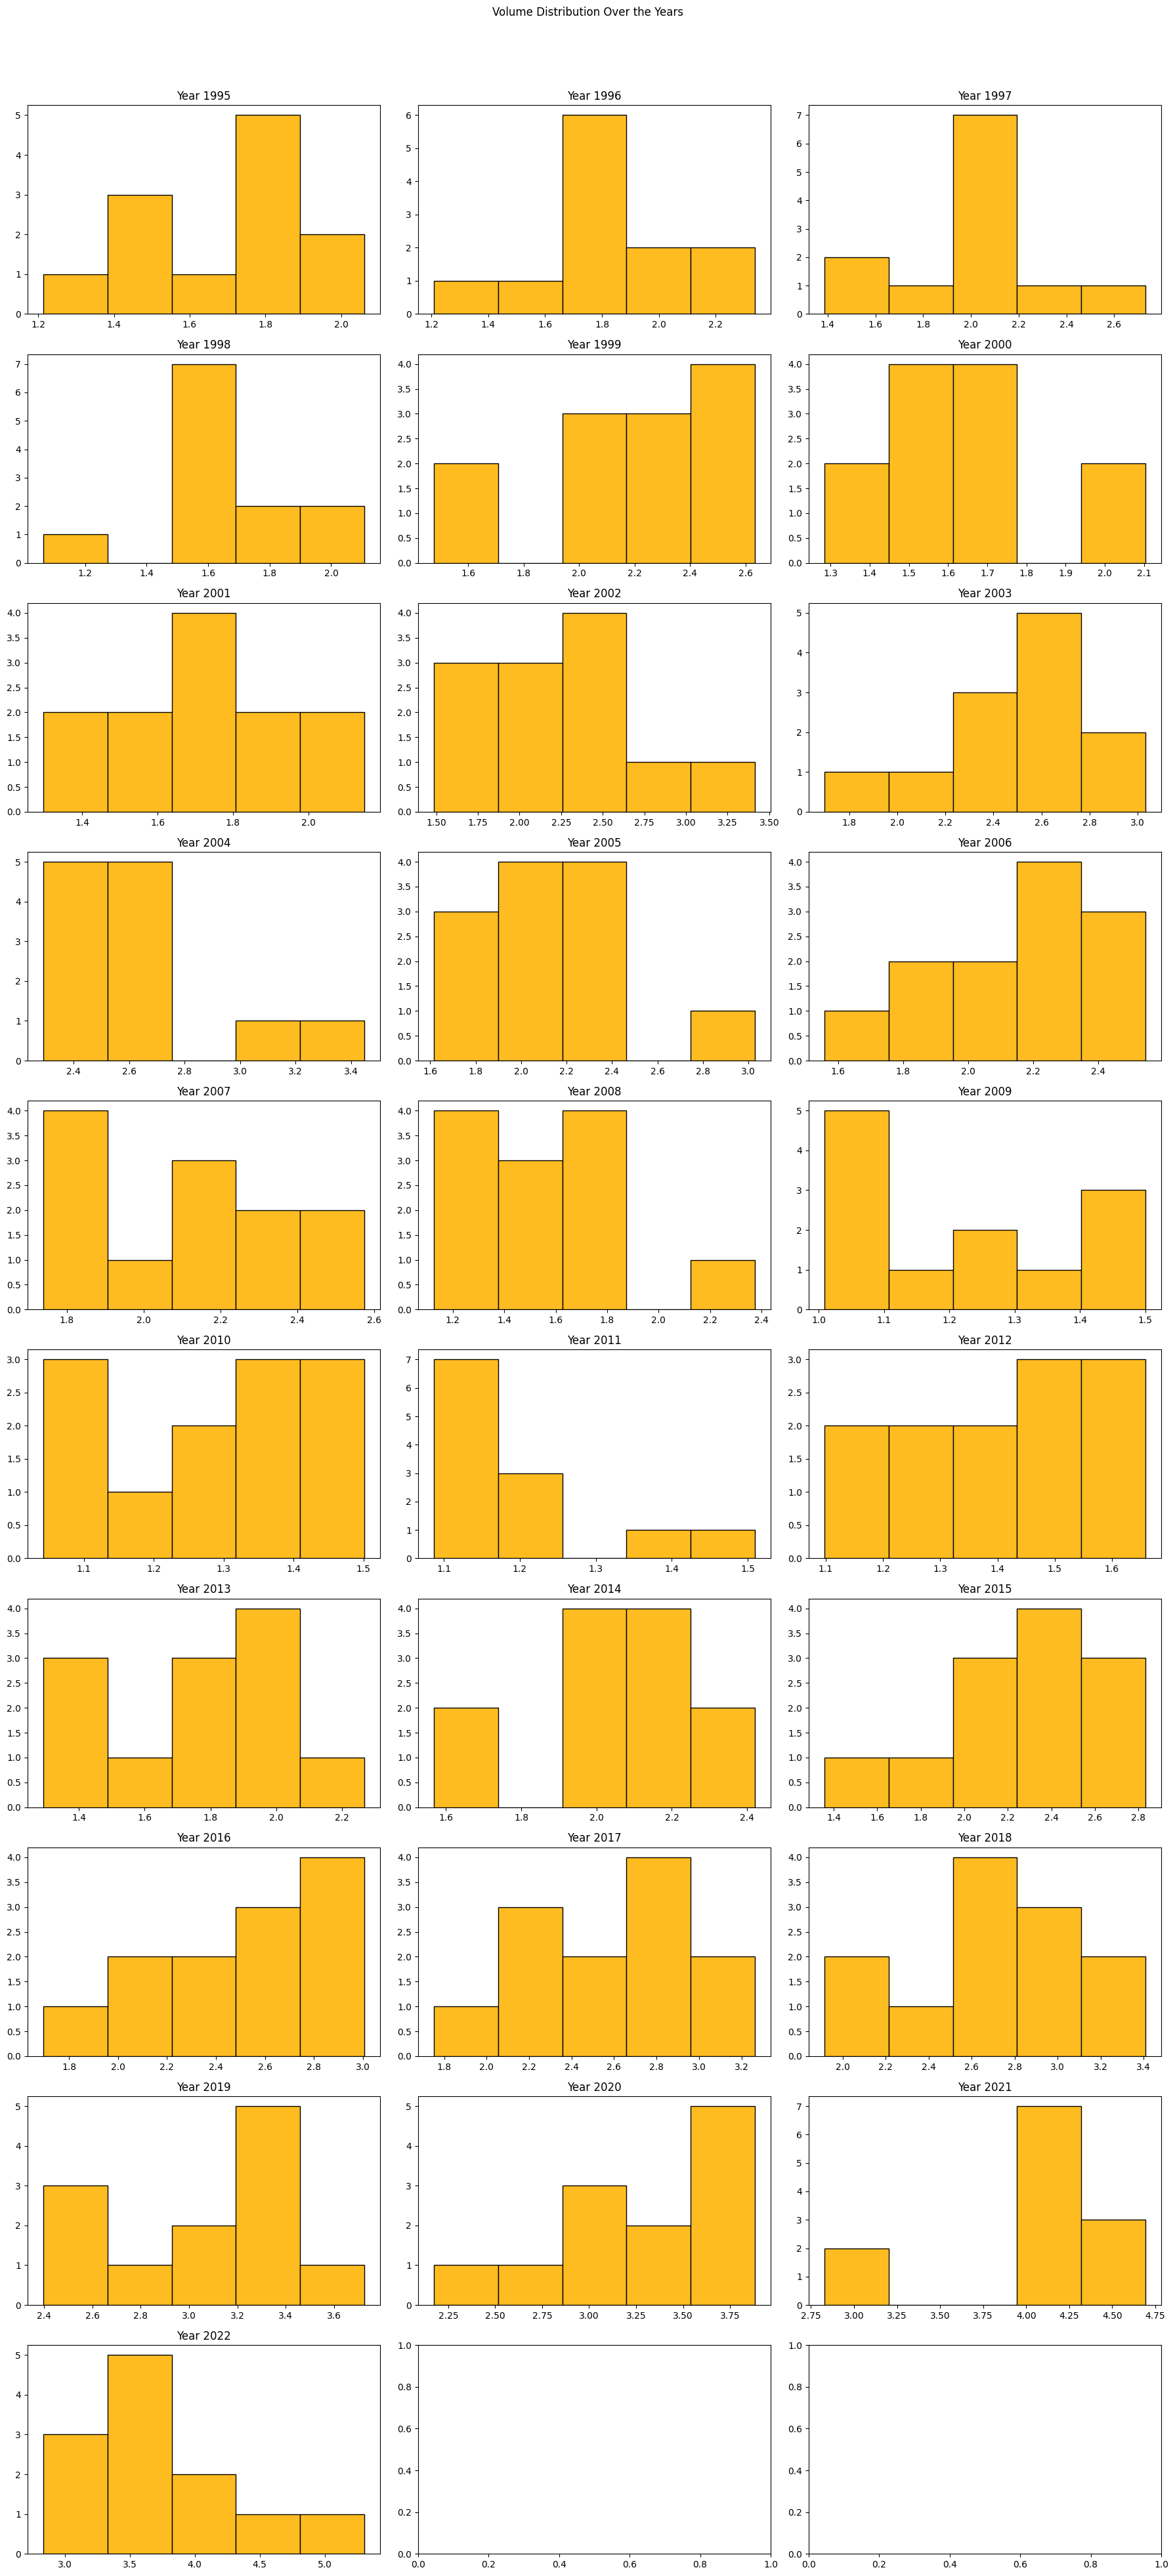

In [584]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 40))
fig.suptitle("Volume Distribution Over the Years")
[g for g in data.groupby('Year')]
for idx, (year, g) in enumerate(data.groupby('Year')):
    row = idx // 3
    col = idx % 3

    min_vol, max_vol = min(g['Actual']), max(g['Actual'])
    num_bins = 2 + int(3.2222 * np.log10(len(g['Actual'])))
    bins = np.linspace(min_vol, max_vol, num_bins + 1)
    axes[row, col].hist(g['Actual'], bins=bins, edgecolor='black', color='#ffbc21')
    axes[row, col].set_title(f"Year {year}")
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # управление расположением заголовка
plt.savefig(f"./assets/volume_hist_years.png")
plt.show()

### Расчет индекса сезонности

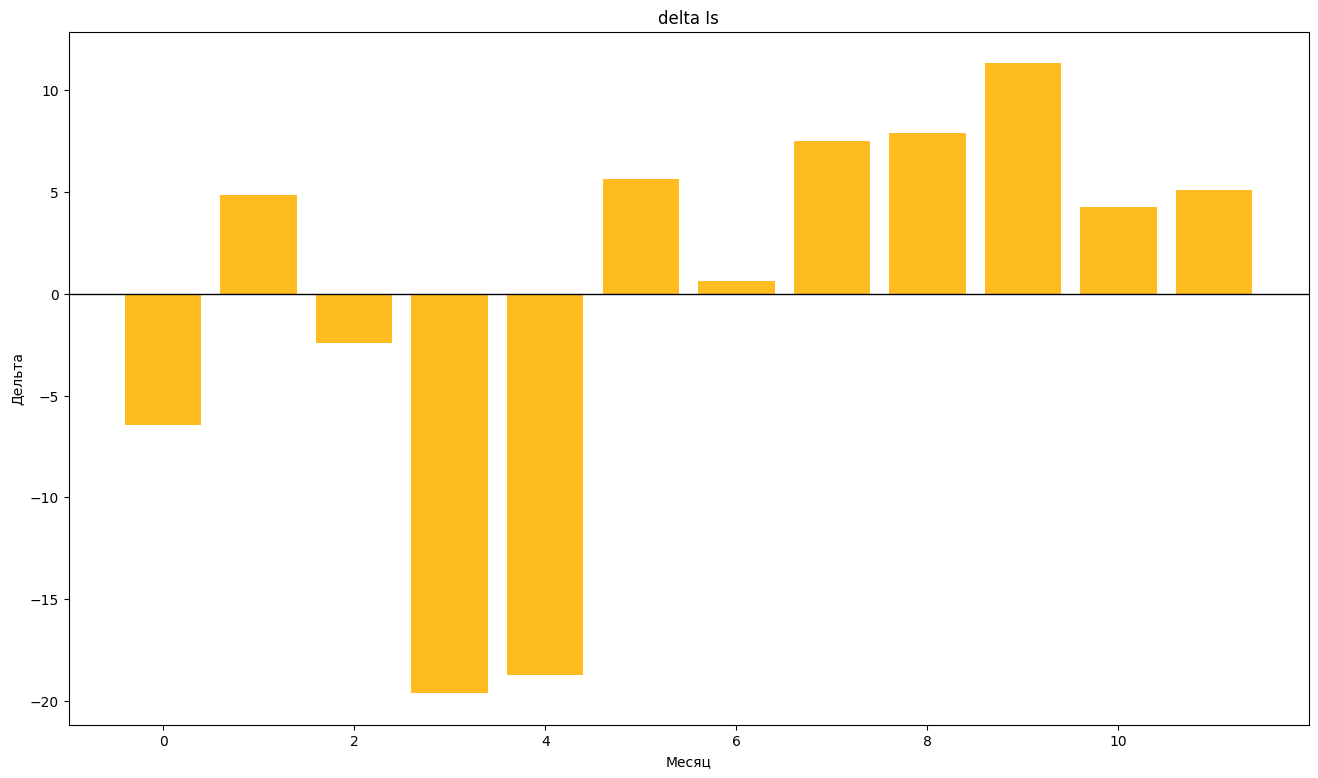

In [585]:
data_months_mean = np.mean(data_months)

df_months = pd.DataFrame()
df_months['Month mean'] = data_months
df_months['Season index'] = df_months['Month mean'] * 100 / data_months_mean
df_months['Season index delta'] = df_months['Season index'] - 100
season_index_delta = df_months['Season index delta'].to_list()

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(np.arange(len(season_index_delta)), np.maximum((season_index_delta), 0), color='#ffbc21')
ax.bar(np.arange(len(season_index_delta)), np.minimum((season_index_delta), 0), color='#ffbc21')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Месяц')
ax.set_ylabel('Дельта')
plt.title('delta Is')
plt.show()

### Сглаживание методом скользящей средней

In [586]:
data_years_g = [g for g in data.groupby('Year')]
for year, g in data_years_g:
    vol = g['Actual'].to_list()
    lst = [(vol[i-1] + vol[i] + vol[i+1] + vol[i+2]) / 4 for i in range(1, len(vol) - 2)]
    tail = (lst[-1] - lst[0]) / len(lst)
    lst = [lst[0] - tail] + lst 
    lst = lst + [lst[-1] + tail]
    lst = lst + [lst[-1] + tail]
    g['Slided'] = lst



### Определение сезонной компоненты

In [587]:
for year, g in data_years_g:
    g['Season'] = g['Actual'] - g['Slided']

season_mean = np.array([0.0] * 12)
for year, g in data_years_g:
    season_mean += g['Season'].to_list()
season_mean /= 12

c = np.mean(season_mean) / 12
season_mean -= c

season_mean


array([-0.39260352, -0.51696232,  0.52416268, -0.44306649,  0.31080851,
       -0.20327482,  0.08776685,  0.00174601, -0.05839982, -0.00810815,
        0.27194972, -0.50574241])

### Структурная идентификация

In [588]:
v = data['Actual'][-5:].reset_index(drop=True)
u = list(range(len(v)))
mn, mx = 0, max(u)
xs = (mn + mx) // 2
for i in range(len(u) - 1):
    if xs >= u[i] and xs <= u[i+1]:
        break

x, y = u, v
y1, yn = y[0], y[len(y) - 1]
x1, xn = x[0], x[len(x) - 1]

ys = y[i] + (y[i+1] - y[i]) * (xs - x[i]) / (x[i+1] - x[i])

ident = {
    "Прямая": abs(ys - (y1 + yn) / 2),
    "Степенная": abs(ys - np.sqrt(y1 * yn)),
    "Гиперболическая": abs(ys - 2 * y1 * yn / (y1 + yn))
}

for k, v in sorted(ident.items(), key=lambda x: x[1]):
    print(v, k)

0.06599999999999984 Прямая
0.06629763206714356 Степенная
0.06659523809523771 Гиперболическая


### Предсказание на будущий год

In [589]:
from scipy.optimize import curve_fit


Y = list(np.array(list(y)).flatten())
l = len(Y)
X = np.array(range(l)).reshape(-1, 1)

# Power function to fit
def power_function(x, a, b):
    return a + x * b

# Fit the power function to the data
params, covariance = curve_fit(power_function, X.flatten(), Y)
print("params: ", *params)
covariance, stdx, stdy = 0, 0, 0
for i in range(len(Y)):
    covariance += (X.flatten()[i] - np.mean(X.flatten())) * (Y[i] - np.mean(Y))
    stdx += (X.flatten()[i] - np.mean(X.flatten()))**2
    stdy += (Y[i] - np.mean(Y))**2
stdx, stdy = stdx**0.5, stdy**0.5

print("Covariance:", covariance / len(Y))
corellation = covariance / (stdx * stdy)
print("Corellation(Pirson):", corellation)

# Generate values for the plot
X_plot = np.linspace(0, l, l)
Y_plot_power = power_function(X_plot, *params)

print(f'Model: {params[0]:.2f} + {abs(params[1]):.2f}x')

def predict_month(month_idx):
    return power_function(month_idx, *params)

params:  3.330800000005082 -0.023200000002231436
Covariance: -0.046399999999999955
Corellation(Pirson): -0.18666798856382774
Model: 3.33 + 0.02x


In [590]:
next_year = np.array([predict_month(i+1) for i in range(10)])
#next_year += season_mean[:10]
next_year

array([3.3076, 3.2844, 3.2612, 3.238 , 3.2148, 3.1916, 3.1684, 3.1452,
       3.122 , 3.0988])

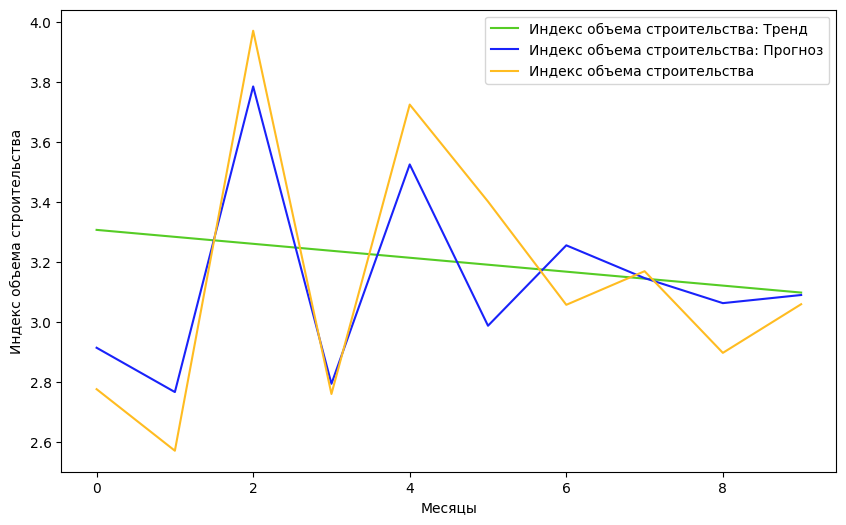

array([-0.39260352, -0.51696232,  0.52416268, -0.44306649,  0.31080851,
       -0.20327482,  0.08776685,  0.00174601, -0.05839982, -0.00810815])

In [591]:
predict = next_year
real = df[-10:]['Actual'].to_list()

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(predict)), y=predict, color='#55cc25', label='Индекс объема строительства: Тренд', ax=ax)
sns.lineplot(x=range(len(predict)), y=predict+season_mean[:10], color='#1922fa', label='Индекс объема строительства: Прогноз', ax=ax)
sns.lineplot(x=range(len(real)), y=real, color='#ffbc21', label='Индекс объема строительства', ax=ax)
plt.xlabel('Месяцы')
plt.ylabel('Индекс объема строительства')
plt.savefig("./assets/predict.png")
plt.show()

season_mean[:10]

#### Оценка прогноза

In [592]:
real = np.array(real)
predict += season_mean[:10]
real_mean = np.mean(real)
delta = real - real_mean
E = real - predict
R_sqared = 1 - np.dot(E, E.T) / np.dot(delta, delta.T)

print(f"R: {R_sqared}")
print(f"r xy: {np.sqrt(R_sqared)}")

R: 0.7901285155201893
r xy: 0.8888917344199964


#### Анализ статистической значимости уравнения регрессии

In [595]:
# тут сделаем критерий Фишера
n = 10
m = 1
y_predict_2023_diff_y_mean = predict - real_mean
s_squared_factor = np.sum(np.power(y_predict_2023_diff_y_mean, 2)) / m # SSR / m
s_sqared_error = np.sum(np.power(real - predict, 2)) / (n - m - 1) # SSE / (n - m - 1)
F = s_squared_factor / s_sqared_error

print(f"F: {F}")

alpha = 0.05
#degree of freedom
df_num = m
df_denum = n - m - 1
f_critical = st.f.ppf(1 - alpha, df_num, df_denum)
print(f"F critical:{f_critical}")

P = 1 - st.f.cdf(F, df_num, df_denum)
print(f"P: {P}")

F: 19.75632179236068
F critical:5.317655071578712
P: 0.0021541203523471886


#### Анализ статистической значимости коэфициентов регрессии

In [596]:
T = st.t.ppf(1 - alpha/2, 9)
tb = np.sqrt(F)
print(T)

b = params[1]
mb = b / tb
print("mb", mb)
delta = T * mb
print("delta", delta)
print(f"interval: [{round(b - delta, 2)}; {round(b + delta, 2)}]")

2.2621571627409915
mb -0.005219572559182655
delta -0.01180749345120137
interval: [-0.01; -0.04]
